## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw

%matplotlib inline

In [2]:
PATH= '/results/SalishSea/longhind.201905/'
start_date = datetime.datetime(2007,1,1)
end_date = datetime.datetime(2007,12,31)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO()
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,NaN,12.0,1982-07-16 01:21:00
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,NaN,21.5,1982-07-16 01:21:00
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,NaN,30.5,1982-07-16 01:21:00
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,NaN,52.3,1982-07-16 01:21:00
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,NaN,75.4,1982-07-16 01:21:00


In [3]:
data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

(Lat,Lon)= 50.605333333333334 -126.3565  not matched to domain
(Lat,Lon)= 50.635 -126.425  not matched to domain
(Lat,Lon)= 50.65533333333333 -126.183  not matched to domain
(Lat,Lon)= 50.66983333333334 -126.067  not matched to domain
(Lat,Lon)= 50.693666666666665 -125.78316666666667  not matched to domain
(Lat,Lon)= 50.72666666666667 -126.182  not matched to domain
(Lat,Lon)= 50.784 -126.61366666666666  not matched to domain
(Lat,Lon)= 50.813 -126.52483333333333  not matched to domain
(Lat,Lon)= 50.84 -126.33  not matched to domain
(Lat,Lon)= 50.93633333333333 -126.4815  not matched to domain
(Lat,Lon)= 51.018 -126.523  not matched to domain
(Lat,Lon)= 51.67516666666667 -127.28466666666667  not matched to domain
(Lat,Lon)= 51.675666666666665 -127.293  not matched to domain
(Lat,Lon)= 51.678 -127.33333333333333  not matched to domain
(Lat,Lon)= 51.67883333333333 -127.3325  not matched to domain


In [28]:
data=data.loc[(data.Lon>-125)|(data.Lat>49.5)].copy(deep=True)

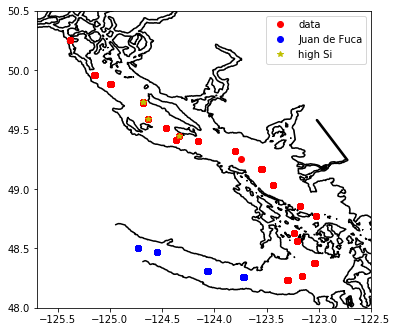

In [30]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

# Nitrate

In [31]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['N']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['N']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['N']],data.loc[data.Z>=22,['mod_nitrate']])
N_d50, modmean_d50, obsmean_d50, bias_d50, RMSE_d50, WSS_d50 = et.stats(data.loc[data.Z>50,['N']],data.loc[data.Z>50,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['N']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('z>50 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d50,bias_d50,RMSE_d50,WSS_d50))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))


Nitrate
z<15 m:
  N: 230
  bias: -1.2235713097323497
  RMSE: 4.255847989866571
  WSS: 0.9150586317545977
15 m<=z<22 m:
  N: 72
  bias: -0.5397076103422371
  RMSE: 3.4291903463406137
  WSS: 0.6551469645892143
z>=22 m:
  N: 758
  bias: -0.7608967773517996
  RMSE: 2.983426158163605
  WSS: 0.7503169984254303
z>50 m:
  N: 589
  bias: -0.7033304029895397
  RMSE: 2.806690277247541
  WSS: 0.7051056505581658
all:
  N: 1060
  bias: -0.8462642513356151
  RMSE: 3.330720219732078
  WSS: 0.9087971687026264


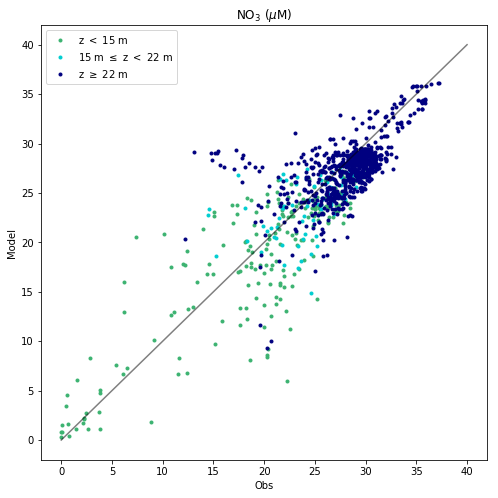

In [32]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')
ax.plot((0,40),(0,40),'k-',alpha=.5)

Nitrate, z<15
Feb-Mar:
  N: 3
  bias: 0.23173154195149692
  RMSE: 2.182800057340376
  WSS: 0.0
April:
  N: 60
  bias: 1.3976398722330714
  RMSE: 4.0477357765953474
  WSS: 0.7288398622458612
May-Jun:
  N: 59
  bias: -2.5303695213996775
  RMSE: 5.055085275454681
  WSS: 0.8899655722843602
Sep-Oct:
  N: 93
  bias: -2.381046353617023
  RMSE: 4.058996700002883
  WSS: 0.8407812134840777


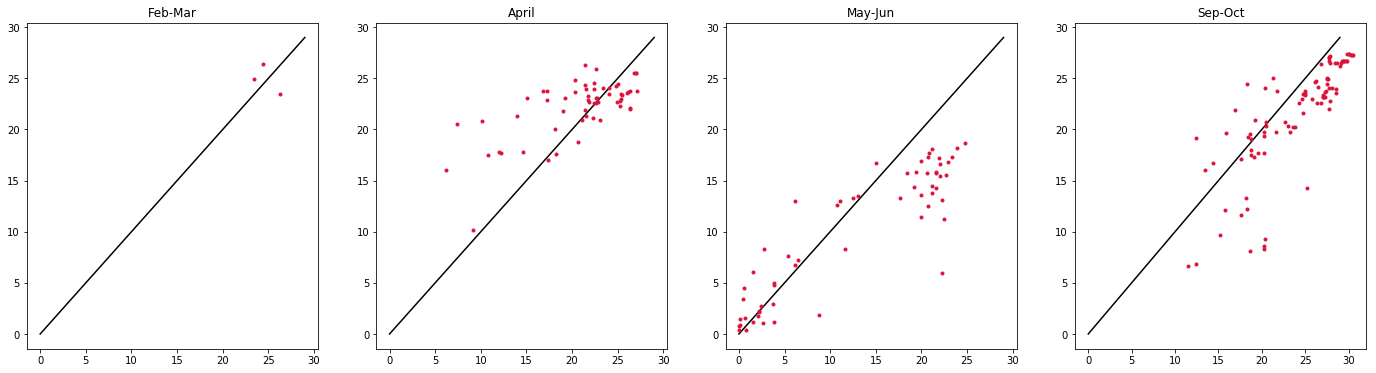

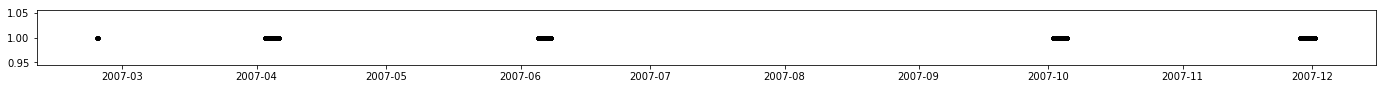

In [33]:
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2007,4,1)),:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2007,5,1))&(data.dtUTC>dt.datetime(2007,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2007,9,1))&(data.dtUTC>dt.datetime(2007,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2007,12,1))&(data.dtUTC>dt.datetime(2007,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

#ii4=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,4,1))&(data.dtUTC>dt.datetime(2016,2,1))
#ps=et.varvarPlot(ax[0],data.loc[ii4,:],obsvar,modvar,cols=('darkturquoise','navy'))
#ii5=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,5,1))&(data.dtUTC>dt.datetime(2016,4,1))
#ps=et.varvarPlot(ax[1],data.loc[ii5,:],obsvar,modvar,cols=('darkturquoise','navy'))

print('Nitrate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2007,4,1)),:],'N','mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],'N','mod_nitrate')
print('May-Jun:')
et.printstats(data.loc[ii2,:],'N','mod_nitrate')
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],'N','mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

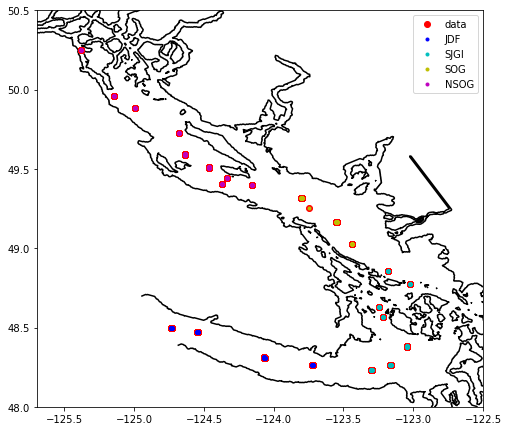

In [34]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

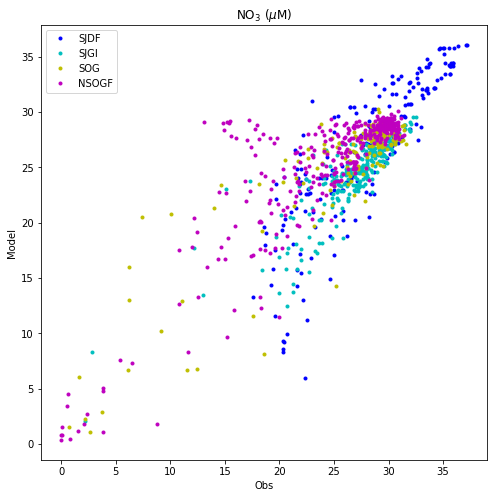

In [35]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,'N','mod_nitrate',cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,'N','mod_nitrate',cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,'N','mod_nitrate',cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,'N','mod_nitrate',cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

(-40, 20)

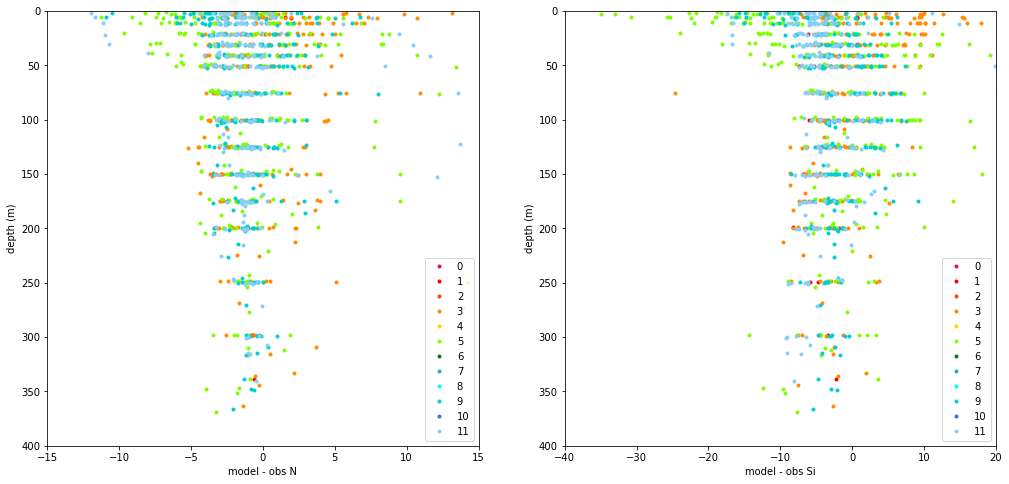

In [36]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan','darkturquoise','royalblue',
      'lightskyblue','blue','darkblue','mediumslateblue','blueviolet','darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[1].set_xlabel('model - obs Si')
ax[0].set_xlim(-15,15)
ax[1].set_xlim(-40,20)

# Silicate

In [37]:
print('Nitrate')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],'Si','mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],'Si','mod_silicon')
print('all:')
et.printstats(data,'Si','mod_silicon')
print('obs Si < 50:')
et.printstats(data.loc[data.Si<50,:],'Si','mod_silicon')

Nitrate
z<15 m:
  N: 230
  bias: -4.544381833283801
  RMSE: 10.338325137365718
  WSS: 0.8342595027789222
15 m<=z<22 m:
  N: 72
  bias: -1.920664638943137
  RMSE: 7.099894681448072
  WSS: 0.7046543855536094
z>=22 m:
  N: 758
  bias: -1.2966310631945817
  RMSE: 6.156321087077122
  WSS: 0.8396646233760691
all:
  N: 1060
  bias: -2.0437188882647845
  RMSE: 7.329216151663646
  WSS: 0.8747131918294353
obs Si < 50:
  N: 503
  bias: -1.151461911059279
  RMSE: 9.331565760805493
  WSS: 0.7494672762458292


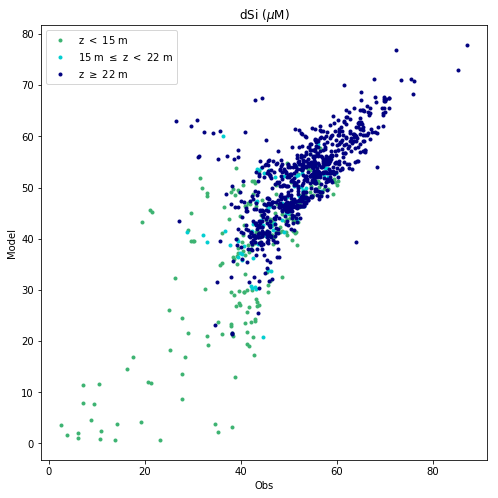

In [38]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')

Silicate, z<15
Feb-Mar:
  N: 3
  bias: -0.7127410888671903
  RMSE: 2.0553099395330916
  WSS: 0.22782897613215636
April:
  N: 60
  bias: 4.053257815043118
  RMSE: 8.852348374354806
  WSS: 0.46314683471518536
May-Jun:
  N: 59
  bias: -12.376140982417741
  RMSE: 15.04923946097487
  WSS: 0.7118092048271505
Sep-Oct:
  N: 93
  bias: -6.068879010600433
  RMSE: 7.573649046057342
  WSS: 0.7335796080795798


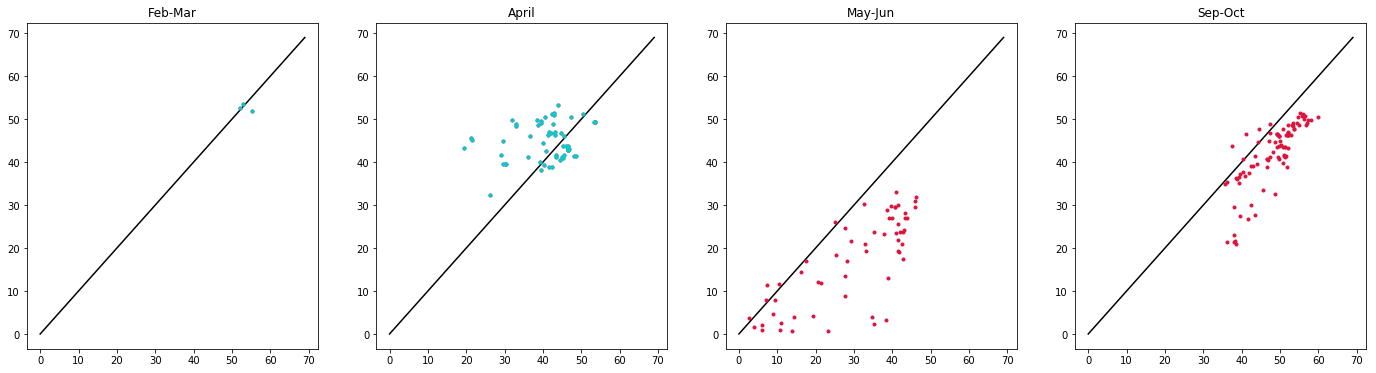

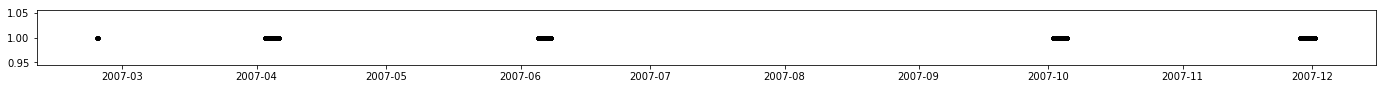

In [47]:
obsvar='Si'; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2007,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(2007,5,1))&(data.dtUTC>dt.datetime(2007,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(2007,9,1))&(data.dtUTC>dt.datetime(2007,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(2007,12,1))&(data.dtUTC>dt.datetime(2007,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

ii4=(data.Z < 15)&(data.dtUTC<=dt.datetime(2007,4,1))&(data.dtUTC>dt.datetime(2007,2,1))
ps=et.varvarPlot(ax[0],data.loc[ii4,:],obsvar,modvar,cols=('darkturquoise','navy'))
ii5=(data.Z < 15)&(data.dtUTC<=dt.datetime(2007,5,1))&(data.dtUTC>dt.datetime(2007,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii5,:],obsvar,modvar,cols=('darkturquoise','navy'))


print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(2007,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

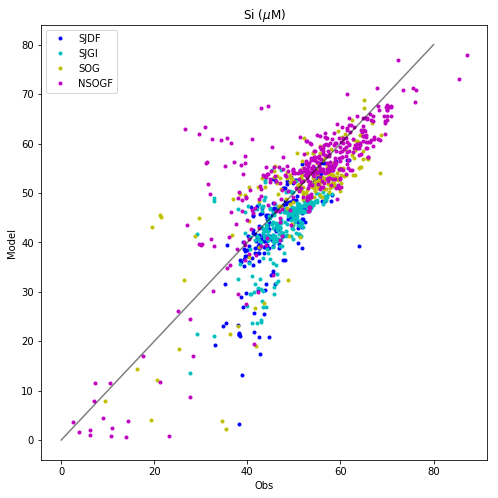

In [40]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Si ($\mu$M)')
ax.plot((0,80),(0,80),'k-',alpha=.5)

# Ratios

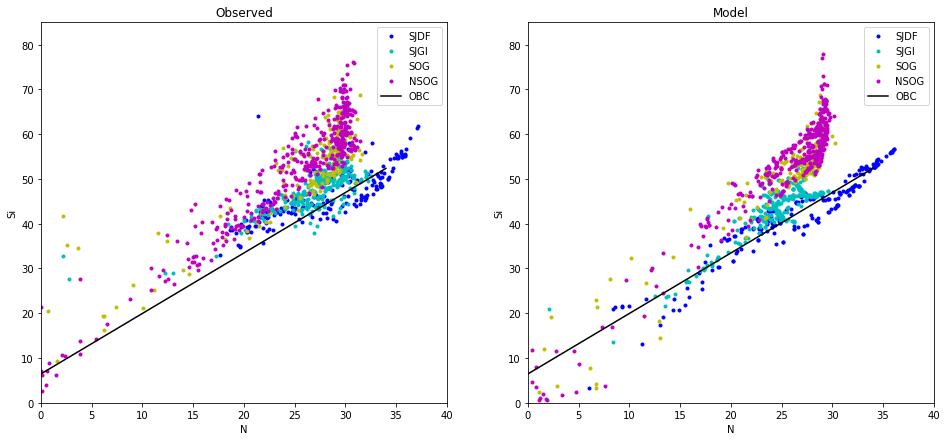

In [41]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].plot(np.arange(0,35),1.35*np.arange(0,35)+6.46,'k-',label='OBC')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].plot(np.arange(0,35),1.35*np.arange(0,35)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

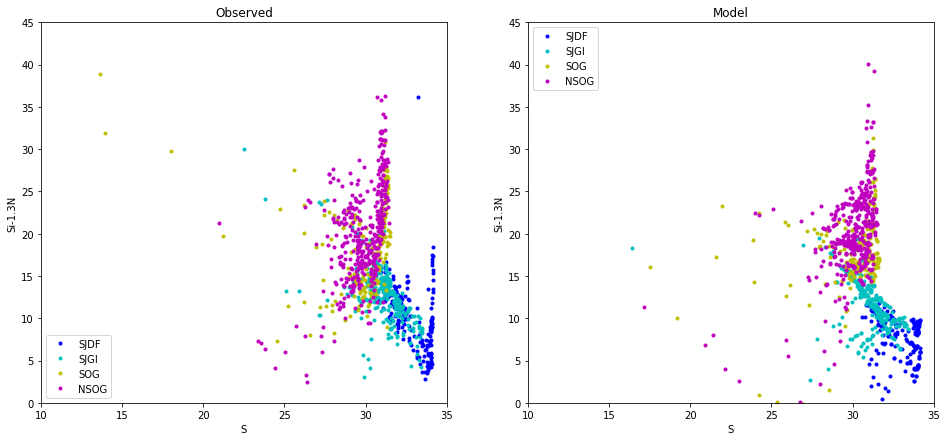

In [42]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['AbsSal'], dJDF['Si']-1.3*dJDF['N'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['AbsSal'],dSJGI['Si']-1.3*dSJGI['N'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['AbsSal'],dSOG['Si']-1.3*dSOG['N'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['AbsSal'],dNSOG['Si']-1.3*dNSOG['N'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('S')
ax[0].set_ylabel('Si-1.3N')
ax[0].set_xlim(10,35)
ax[0].set_ylim(0,45)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_vosaline'],dJDF['mod_silicon']-1.3*dJDF['mod_nitrate'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_vosaline'],dSJGI['mod_silicon']-1.3*dSJGI['mod_nitrate'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_vosaline'],dSOG['mod_silicon']-1.3*dSOG['mod_nitrate'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_vosaline'],dNSOG['mod_silicon']-1.3*dNSOG['mod_nitrate'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('S')
ax[1].set_ylabel('Si-1.3N')
ax[1].set_xlim(10,35)
ax[1].set_ylim(0,45)
ax[1].legend()

In [43]:
data.loc[data.Si>65,['Month','Lat','Lon','Z','Si']]

,Month,Lat,Lon,Z,Si
163,4.0,49.029667,-123.436500,298.526000,68.7
186,4.0,49.163333,-123.550000,363.262093,66.8
217,4.0,49.401500,-124.154833,268.812556,65.5
255,4.0,49.587667,-124.638333,149.458397,66.0
256,4.0,49.587667,-124.638333,159.959987,65.9
271,4.0,49.726833,-124.680333,298.309008,66.9
272,4.0,49.726833,-124.680333,343.844435,69.6
453,6.0,49.029667,-123.437000,298.426992,68.4
486,6.0,49.318167,-123.799667,297.825099,65.1
487,6.0,49.318167,-123.799667,338.215150,65.1


# Chlorophyll

In [44]:
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

In [45]:
print('log10[Chl+0.01]')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'l10_obsChl','l10_modChl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'l10_obsChl','l10_modChl')
print('all:')
et.printstats(data,'l10_obsChl','l10_modChl')
print('\n')
print('Chl')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Chlorophyll_Extracted','mod_Chl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'Chlorophyll_Extracted','mod_Chl')
print('all:')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')


log10[Chl+0.01]
z<15 m:
  N: 164
  bias: -0.10146374862072044
  RMSE: 0.42447788977976136
  WSS: 0.7784561026448158
z>=15 m:
  N: 85
  bias: -0.04407948028245359
  RMSE: 0.343450850912796
  WSS: 0.7142357333372242
all:
  N: 249
  bias: -0.08187474135665343
  RMSE: 0.3986736742473352
  WSS: 0.7877385388383967


Chl
z<15 m:
  N: 164
  bias: -0.5546398011424665
  RMSE: 2.776444293608994
  WSS: 0.7581034237908935
z>=15 m:
  N: 85
  bias: -0.221569588031291
  RMSE: 0.8779965845452986
  WSS: 0.6945217669817031
all:
  N: 249
  bias: -0.44094113401616153
  RMSE: 2.3109153147151846
  WSS: 0.7741367904198293


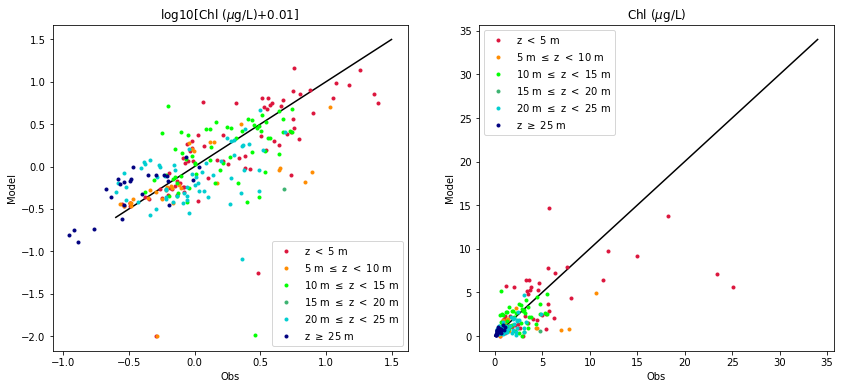

In [46]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01]')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L)')